<a href="https://colab.research.google.com/github/leeminseo0809/study/blob/master/multilayer_perceptron_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Multilayer Perceptron (Numpy-Implementation)**

A multilayer perceptron is a special case of a feed-forward neural network where every layer is a fully connected layer.

\
In this particular instance, we define the dimensions of $x$ and $y$ to be $dim(x)=2$ and $dim(y)=1$, respectively.

The architecture of the feed-forward neural network is depicted below.
 <p align="center"><img src='https://drive.google.com/uc?export=download&id=1IVE3pvXvRbdnlyfyKWBLCLHw0yXs6NMu' width="400" height ="" /><br></p>

It is noteworthy that the value "1" serves as an input to the network as well.





In [ ]:
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### **Create Data**

In [ ]:
# Create train-data
n_train = 10000
x1 = np.random.uniform(low=-2.1, high=+2.1, size=n_train) # 1차원 배열로 생성
x2 = np.random.uniform(low=-2.1, high=+2.1, size=n_train)
#x1 = np.random.normal(0.0, 1.0, size=n_train)
#x2 = np.random.normal(0.0, 1.0, size=n_train)
x1 = np.reshape(x1, (-1, 1)) # -1은 차원의 크기를 자동 계산하라는 의미
x2 = np.reshape(x2, (-1, 1))
_x = np.concatenate((x1, x2), axis=-1) # 두 열 벡터를 붙여서 (10000,2) 모양의 배열 _x를 만듦
xtrain = np.concatenate((_x, np.ones((n_train, 1))), axis=-1)  # Add '1', (10000, 3) 배열
xtrain = xtrain.astype(np.float32) # 데이터 타입을 32비트 실수로 변환

# Set ytrain
ytrain = np.zeros((n_train,1), dtype=np.float32) # (10000,1) 모양의 배열을 0으로 초기화
for i in range(0, n_train):
  ytrain[i, 0] = np.exp(-(xtrain[i, 0]**2 + xtrain[i, 1]**2))

In [ ]:
## Create test-data
n_test_grid = 20
n_test = n_test_grid * n_test_grid # 전체 테스트 포인트 개수는 20*20 = 400개
x1grid = np.linspace(-2.0, +2.0, n_test_grid) # [-2.0, 2,0] 구간을 등간격으로 나눈 20개의 1차원 배열
x2grid = x1grid.copy() # x1grad와 같은 값을 갖는 x2grid를 복사하여 생성
X1grid, X2grid = np.meshgrid(x1grid, x2grid) # 1차원 배열 x1grid, x2grid로부터 격자 좌표 생성, (20,20) 형태의 2D 배열
Ygrid = np.exp(-(X1grid**2 + X2grid**2))

x1test = np.reshape(X1grid, (-1, 1)) # (400,1) 모양의 열 벡터로 펼침
x2test = np.reshape(X2grid, (-1, 1))
_xtest = np.concatenate((x1test, x2test), axis=-1) # (400,2) 배열 _xtest를 만듦
xtest = np.concatenate((_xtest, np.ones((n_test, 1))), axis=-1)  # Add '1', (400,3) 배열을 만듦
ytest = np.reshape(Ygrid, (-1, 1))

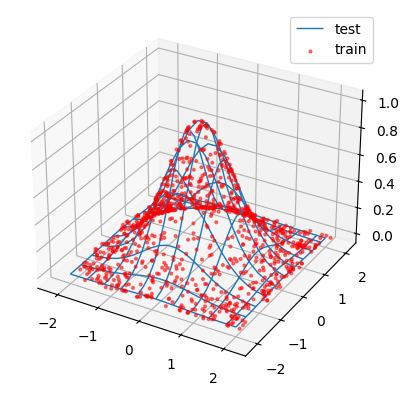

In [ ]:
# Reduce number of data to plot
sample_idx = np.random.choice(xtrain.shape[0], size=1000, replace=False) # replace=False : 중복 불허, 훈련 샘플 총 개수 중에서 1000개를 무작위로 뽑아낼 배열 sample_idx를 생성
x_sample = xtrain[sample_idx]
y_sample = ytrain[sample_idx]

# Draw data
fig = plt.figure() # 새로운 그림 객체를 만듦
ax = fig.add_subplot(111, projection='3d') # 이 그림에 3D 축 하나 추가, 111은 1행 1열에 첫 번째 subplot
ax.plot_wireframe(X1grid, X2grid, Ygrid, rstride=2, cstride=2, linewidth=1, label='test') # rstride=2, cstride=2: 행(row)과 열(column) 방향으로 등간격마다 선을 그리겠다는 뜻(간격 2)
ax.scatter(x_sample[:, 0], x_sample[:, 1], y_sample.ravel(), s=4, c='r', marker='o', alpha=0.5, label='train') # scatter로 샘플링한 1,000개의 훈련 데이터 포인트를 3D 산점도로 표시
ax.set_xlim([-2.5, +2.5]) # x축과 y축 표시 범위를 [-2.5, +2.5]로 고정
ax.set_ylim([-2.5, +2.5])
ax.legend(loc='upper right')
plt.show()

###**Define the Feed-Forward Neural Network**

The feed-forward neural network is trained by minimizing the l2-loss-function:
$$ l(y, \hat{y}) = |y - \hat{y}|^2.$$

The gradients of network parameters are computed manually in this code example.

In [7]:
class MLP(object):
  def __init__(self, **kwargs): # 모든 키워드 인자(dim_x, dim_h, learning_rate 등)를 self 객체의 속성으로 한꺼번에 설정
    self.__dict__.update(kwargs)
    self.W1 = self.init_weight(self.dim_x, self.dim_h) # 입력 -> 은닉 유닛 수
    self.W2 = self.init_weight(self.dim_h, self.dim_h) # 은닉 -> 은닉
    self.W3 = self.init_weight(self.dim_h, 1) # 은닉 -> 출력

  @staticmethod
  def init_weight(dim1, dim2): # 가중치 초기화 함수
    _W1 = np.random.normal(0.0, 1.0/dim1, size=((dim1-1), dim2)) # 평균 0, 표준편차 1/dim1로 가우시안 초기화, (dim1-1, dim2)
    _W2 = np.zeros((1, dim2), dtype=np.float32) # bias 행을 0으로 초기화. (1, dim2)
    _W = np.concatenate((_W1, _W2), axis=0) # 순수 연결 가중치(_W1)와 bias(_W2)를 쌓아 최종 (dim1, dim2) 모양 가중치 반환
    _W = _W.astype(np.float32)
    return _W

  @staticmethod
  def tanh(x): # 활성화 함수로 tanh 사용
    """Activation function (tanh)."""
    return np.tanh(x)

  @staticmethod
  def grad_tanh(x): # tanh 도함수
    """Gradient of activation function (tanh)."""
    return 1 - np.tanh(x) * np.tanh(x)

  def get_h(self, x, W): # 한 층의 선형변환과 활성화 결과를 계산
    _h = np.matmul(x, W) # 선형 출력
    h = self.tanh(_h)  # [None, dim_h], 활성화 후 출력
    return h, _h

  def pred_y(self, x): # 순전파
    h1, v = self.get_h(x, self.W1)
    h2, z = self.get_h(h1, self.W2)
    y = np.matmul(h2, self.W3)  # [None, 1]
    return y, h1, h2, v, z

  def compute_grad(self, x, y_true): # 역전파
    y_pred, h1, h2, v, z = self.pred_y(x)
    n = np.shape(x)[0]

    diff_y = -2.0*(y_true - y_pred)  # [None, 1]
    diff_y = diff_y.astype(np.float32)
    delta_v = self.grad_tanh(v)  # [None, dim_h], 각 은닉층 pre-activation에 대한 도함수 값 준비
    delta_z = self.grad_tanh(z)  # [None, dim_h]

    # Compute dW1 [None, dim_x, dim_h]
    dW1 = self.compute_gradW1(n, x, diff_y, delta_z, delta_v)

    # Compute dW2 [None, dim_h, dim_h]
    dW2 = self.compute_gradW2(n, h1, diff_y, delta_z)

    # Compute dW3 [None, dim_h]
    dW3 = self.compute_gradW3(h2, diff_y)

    return dW1, dW2, dW3 # 각 층별 가중치 기울기를 계산해 반환

  def compute_gradW1(self, n, x, diff_y, delta_z, delta_v): # 입력층→1층 은닉 가중치 W1의 기울기 계산
    _diff_y = np.expand_dims(diff_y, axis=-1)  # [None, 1, 1]
    _diff_y = np.repeat(_diff_y, repeats=self.dim_x, axis=1)  # [None, dim_x, 1]
    _diff_y = np.repeat(_diff_y, repeats=self.dim_h, axis=2)  # [None, dim_x, dim_h]

    _W3 = np.reshape(self.W3, (1, self.dim_h))  # [1, dim_h]
    _W3 = np.repeat(_W3, repeats=n, axis=0)  # [None, dim_h]
    _W3z = _W3 * delta_z  # [None, dim_h]
    _W3zW2 = np.matmul(_W3z, self.W2)  # [None, dim_h]
    _W3zW2 = np.expand_dims(_W3zW2, axis=1)  # [None, 1, dim_h]
    _W3zW2 = np.repeat(_W3zW2, repeats=self.dim_x, axis=1)  # [None, dim_x, dim_h]

    _delta_v = np.expand_dims(delta_v, axis=1)  # [None, 1, dim_h]
    _delta_v = np.repeat(_delta_v, repeats=self.dim_x, axis=1)  # [None, dim_x, dim_h]

    _x = np.expand_dims(x, axis=-1)  # [None, dim_x, 1]
    _x = np.repeat(_x, repeats=self.dim_h, axis=-1)  # [None, dim_x, dim_h]

    dW1 = _diff_y * _W3zW2 * _delta_v * _x  # [None, dim_x, dim_h]
    dW1 = np.reshape(np.mean(dW1, axis=0), (self.dim_x, self.dim_h))  # [dim_x, dim_h]
    return dW1

  def compute_gradW2(self, n, h1, diff_y, delta_z): # 1층 은닉→2층 은닉 가중치 W2의 기울기 계산
    _diff_y = np.expand_dims(diff_y, axis=-1)  # [None, 1, 1]
    _diff_y = np.repeat(_diff_y, repeats=self.dim_h, axis=1)  # [None, dim_h, 1]
    _diff_y = np.repeat(_diff_y, repeats=self.dim_h, axis=2)  # [None, dim_h, dim_h]

    _W3 = np.expand_dims(self.W3, axis=0)  # [1, dim_h, 1]
    _W3 = np.reshape(_W3, (1, 1, self.dim_h))  # [1, 1, dim_h]
    _W3 = np.repeat(_W3, repeats=n, axis=0)  # [None, 1, dim_h]
    _W3 = np.repeat(_W3, repeats=self.dim_h, axis=1)  # [None, dim_h, dim_h]

    _delta_z = np.expand_dims(delta_z, axis=1)  # [None, 1, dim_h]
    _delta_z = np.repeat(_delta_z, repeats=self.dim_h, axis=1)  # [None, dim_h, dim_h]

    _h1 = np.expand_dims(h1, axis=-1)  # [None, dim_h, 1]
    _h1 = np.repeat(_h1, repeats=self.dim_h, axis=-1)  # [None, dim_h, dim_h]

    dW2 = _diff_y * _W3 * _delta_z * _h1  # [None, dim_h, dim_h]
    dW2 = np.reshape(np.mean(dW2, axis=0), (self.dim_h, self.dim_h))  # [dim_h, dim_h]
    return dW2

  def compute_gradW3(self, h2, diff_y): # 2층 은닉→출력층 가중치 W3의 기울기 계산
    _diff_y = np.reshape(diff_y, (-1, 1))
    _diff_y = np.repeat(_diff_y, repeats=self.dim_h, axis=1)  # [None, dim_h]
    dW3 = _diff_y * h2  # [None, dim_h]
    dW3 = np.reshape(np.mean(dW3, axis=0), (self.dim_h, 1))  # [dim_h, 1]
    return dW3

  def train(self, x, y_true): # 한 배치에 대해 기울기를 계산한 뒤, 경사 하강법으로 가중치 갱신
    dW1, dW2, dW3 = self.compute_grad(x, y_true)
    self.W1 = self.W1 - self.learning_rate * dW1
    self.W2 = self.W2 - self.learning_rate * dW2
    self.W3 = self.W3 - self.learning_rate * dW3

  def compute_loss(y_true, y_pred): # MSE 계산
    _diffsq = np.square(y_true - y_pred)
    _diffsq = np.reshape(_diffsq, (-1))
    return np.mean(_diffsq)

### **Train the Neural Network**

In [8]:
def get_batch(x, y, i, batchsize):
  _n = np.shape(x)[0] # x 배열의 첫 번째 차원 크기(즉 전체 샘플 수)를 _n에 저장

  if (i+1)*batchsize > _n:
    _ind = np.arange(i*batchsize, _n)
  else:
    _ind = np.arange(i*batchsize, (i+1)*batchsize)

  x_batch = x[_ind, :] # x와 y를 행 단위로 슬라이싱
  y_batch = y[_ind, :]

  return x_batch, y_batch # 슬라이싱한 한 배치 분량의 입력(x_batch)과 정답(y_batch)을 호출자에게 돌려줌

In [9]:
def shuffle_data(x, y):
  _n = np.shape(x)[0]
  _ind = np.random.permutation(_n) # 0부터 _n-1까지의 정수 인덱스를 무작위 순서(permutation)로 섞은 배열 _ind를 생성
  x = x[_ind, :]
  y = y[_ind, :]
  return x, y

In [10]:
def draw_procedure(X1grid, X2grid, Ygrid, x, ypred):
  """Draw learning procedure."""
  ypred = np.squeeze(ypred) # squeeze는 크기가 1인 차원을 제거
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_wireframe(X1grid, X2grid, Ygrid, rstride=2, cstride=2, linewidths=1.0, label='true') # rstride, cstride: 행·열 방향 그리드 간격
  ax.scatter(x[:, 0], x[:, 1], ypred, s=10, c='m', alpha=0.5, marker='o', label='pred') # x[:, 0], x[:, 1] 각 샘플의 x1, x2 좌표
  ax.legend(loc='upper right')
  plt.show()

[   1] loss-train: 0.0862310/0.0378131, loss-test: 0.0886152


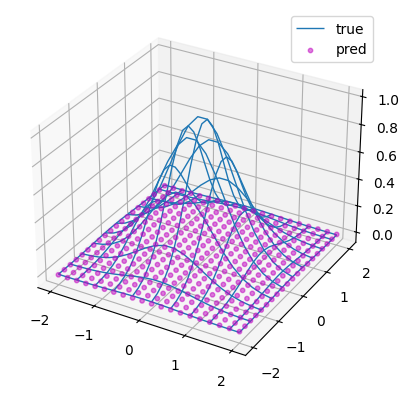

[  50] loss-train: 0.0383886/0.0146202, loss-test: 0.0391508


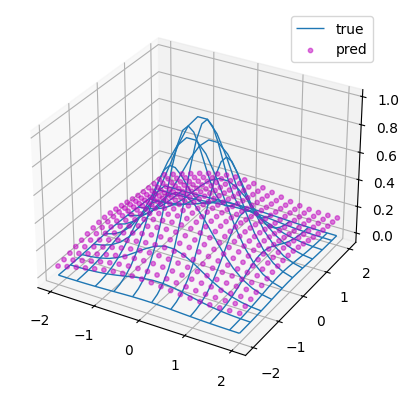

[ 100] loss-train: 0.0053574/0.0015761, loss-test: 0.0052725


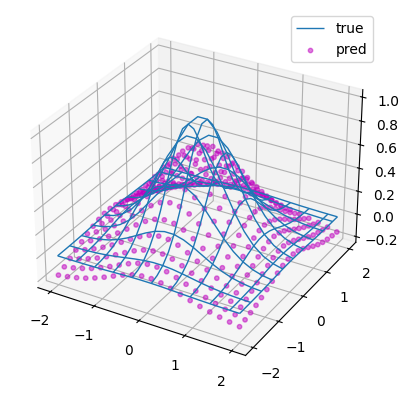

[ 150] loss-train: 0.0019868/0.0004377, loss-test: 0.0019434


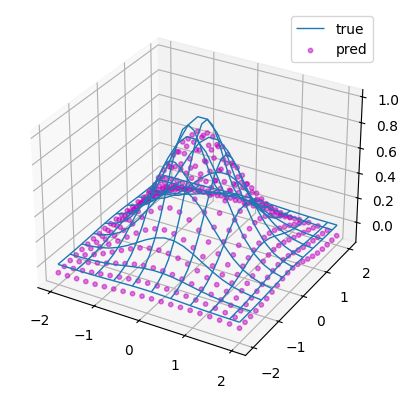

[ 200] loss-train: 0.0010974/0.0002160, loss-test: 0.0010683


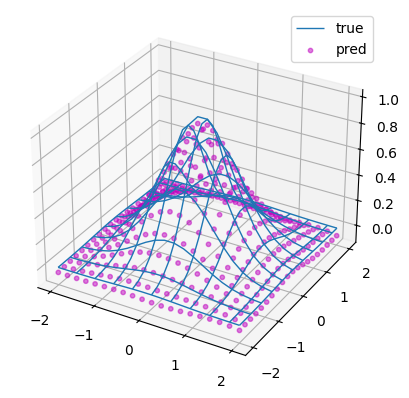

[ 250] loss-train: 0.0006915/0.0001414, loss-test: 0.0006753


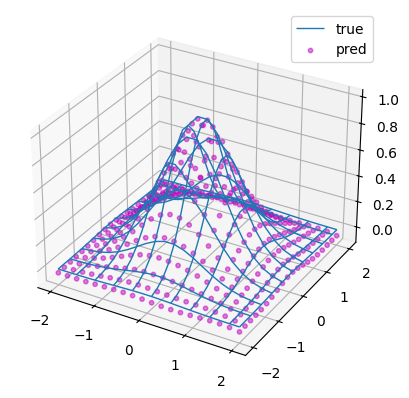

[ 300] loss-train: 0.0004873/0.0001005, loss-test: 0.0004755


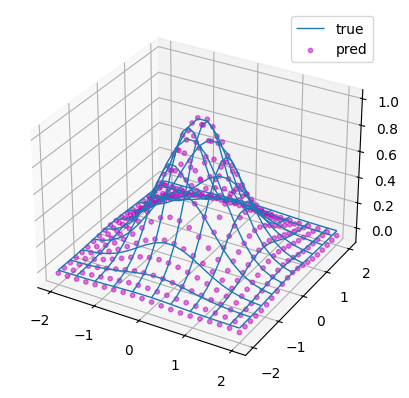

In [ ]:
epochs = 300
batchsize = 25
learningrate = 5e-3 # 경사 하강법에서 가중치 갱신 시 곱해질 학습률
displaystep = 50 # 학습 과정을 화면에 찍을 간격
dim_x = 3 # 입력 벡터 차원 [x1, x2, 1]
dim_h = 64 # 은닉층 유닛 수

mlp = MLP(dim_x=dim_x, dim_h=dim_h, learning_rate=learningrate)

n_batch = int(n_train/batchsize) # 한 에폭당 미니배치 수 계산
_xtrain = np.copy(xtrain) # 원본 데이터를 보존하기 위해 복사본 생성
_ytrain = np.copy(ytrain)
loss_list = [] # 에폭별 손실 기록을 저장할 빈 리스트 초기화
for epoch in range(epochs):
  _loss = [] # 한 에폭 동안의 배치별 손실을 모아둘 리스트 _loss 초기화
  for i in range(n_batch):
    _xbatch, _ybatch = get_batch(_xtrain, _ytrain, i, batchsize)
    _ypred, _, _, _, _ = mlp.pred_y(_xbatch) # mlp에 미니배치 입력을 넣어 예측값 _ypred 계산, _로 표시된 나머지 은닉층 출력 등은 이번 단계에서 사용하지 않음
    _l = compute_loss(_ybatch, _ypred) # 예측값과 정답 배치로부터 MSE 손실 _l 계산
    _loss.append(_l) # _loss 리스트에 배치 손실 추가

    mlp.train(_xbatch,_ybatch)

  # Update loss-list
  _l_mean = np.mean(_loss)
  _l_std = np.std(_loss)
  loss_list.append([_l_mean, _l_std]) # 에폭 내 모든 배치 손실의 평균(_l_mean)과 표준편차(_l_std) 계산

  # Shuffle data
  _xtrain, _ytrain = shuffle_data(_xtrain, _ytrain)

  if (epoch + 1) % displaystep == 0 or (epoch+1) in [1]: # 첫 번째 에폭이 끝났을 때, 또는 displaystep의 배수 에폭일 때
    ypred_test, _, _, _, _ = mlp.pred_y(xtest) # xtest에 대해 현재 모델 예측 ypred_test 계산
    l_test = compute_loss(ytest, ypred_test)
    print("[{:4d}] loss-train: {:3.7f}/{:3.7f}, loss-test: {:3.7f}"
      .format(epoch+1,_l_mean, _l_std, l_test))
    draw_procedure(X1grid, X2grid, Ygrid, xtest, ypred_test)

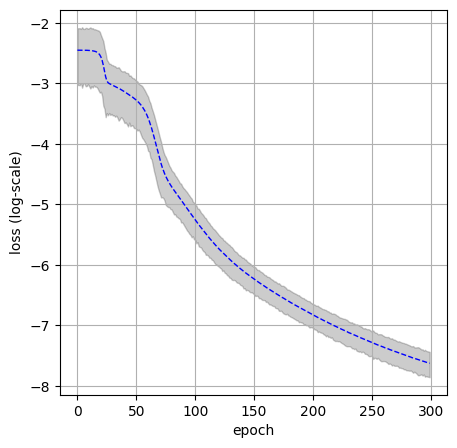

In [ ]:
fig = plt.figure(figsize=(5,5)) # 그림에 하나의 2D 축(Axes) 을 추가해서 ax 변수에 저장
ax = fig.add_subplot()
loss_list = np.array(loss_list) # 이전에 모아둔 loss_list (에폭별 [평균, 표준편차] 리스트)를 NumPy 배열로 변환
plot_xrange = np.arange(0, loss_list.shape[0]) # x축에 쓸 에폭 인덱스 배열을 생성, 0부터 (에폭 수 - 1)까지 정수로 이루어진 1D 배열
l_mean = np.log(loss_list[:, 0]) # 각 에폭의 평균 손실(loss_list[:,0])에 자연로그를 취해 l_mean에 저장
l_upper = np.log(loss_list[:, 0] + loss_list[:, 1]) # 평균 손실에 표준편차를 더하고 뺀 값을 각각 로그 변환해서 에폭별 불확실도(밴드)를 만듦
l_lower = np.log(loss_list[:, 0] - loss_list[:, 1])
ax.plot(plot_xrange, l_mean, 'b--', linewidth=1)
ax.fill_between(plot_xrange, l_upper, l_lower, color='k', alpha=0.2)
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss (log-scale)')
plt.show()